In [262]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

import warnings
warnings.filterwarnings("ignore")

In [94]:
colors = ["#D8BFD8", "#9370DB", "#4B0082"]

### Task (a):
For each user, determine her country based on the numeric IP address.

In [27]:
ip_df = pd.read_csv("IpAddress_to_Country.csv")
ip_df.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [24]:
fraud_df = pd.read_csv("Fraud_data.csv")
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [58]:
fraud_df.shape[0], fraud_df["user_id"].nunique(), fraud_df["device_id"].nunique()

(151112, 151112, 137956)

In [31]:
fraud_df.isna().sum(), \
ip_df.isna().sum()

(user_id           0
 signup_time       0
 purchase_time     0
 purchase_value    0
 device_id         0
 source            0
 browser           0
 sex               0
 age               0
 ip_address        0
 class             0
 dtype: int64,
 lower_bound_ip_address    0
 upper_bound_ip_address    0
 country                   0
 dtype: int64)

In [9]:
label_encoder = LabelEncoder()
ip_df["country_code"] = label_encoder.fit_transform(ip_df["country"])

In [44]:
# with much lower efficiency
# def find_ip_interval(x, ip_df=ip_df):
#     """
#     match the ip address with its corresponding country
#     """
#     for index, row in ip_df.iterrows():
#         if row["lower_bound_ip_address"] <= x <= row["upper_bound_ip_address"]:
#             return row["country"]

# fraud_df["country"] = fraud_df["ip_address"].apply(lambda x: find_ip_interval(x))

In [45]:
countries = []
for i in range(len(fraud_df)):
    ip_address = fraud_df.iloc[i]["ip_address"]
    ip_range_df = ip_df[(ip_df["lower_bound_ip_address"] <= ip_address) & 
                        (ip_df["upper_bound_ip_address"] >= ip_address)]
    if len(ip_range_df) == 1:
        countries.append(ip_range_df["country"].values[0])
    else:
        countries.append('NA')

fraud_df["country"] = countries
fraud_df["country"].value_counts(normalize=True)

United States     0.384146
NA                0.145362
China             0.079663
Japan             0.048348
United Kingdom    0.029713
                    ...   
Myanmar           0.000007
Vanuatu           0.000007
Dominica          0.000007
Niger             0.000007
Guadeloupe        0.000007
Name: country, Length: 182, dtype: float64

### Comments：
- Roughly 14% of the data doesn't match with any IP addresses.

### Task (b):
- Build a model to predict whether an activity is fraudulent or not. 
- Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

### Feature Engineering
- purchase time - signup time
- purchase value
- Number of Users Sharing the Same Device
- source
- browser
- sex
- age
- country

In [52]:
# calculate the interval betwwen first purchase time and signup time
fraud_df["signup_time"] = pd.to_datetime(fraud_df["signup_time"])
fraud_df["purchase_time"] = pd.to_datetime(fraud_df["purchase_time"])
fraud_df["purchase_interval"] = fraud_df.apply(lambda x: (x["purchase_time"]-x["signup_time"]).days, axis=1)

In [59]:
# count the number of users sharing the same device
fraud_df["device_user_cnt"] = fraud_df.groupby("device_id")["user_id"].transform("nunique")

In [191]:
# calculate the proportion of fraudulent users from different sources/browsers/sex
def plot_proportion(col, fraud_df=fraud_df, figsize=(8, 6)):
    plot_df = fraud_df[[col, "class"]].pivot_table(
        index=col, 
        columns="class", 
        aggfunc=len, 
        fill_value=0, 
        margins_name="sum", 
        margins=True).reset_index()\
    .query(f"{col} != 'sum' ").set_index(col)
    plot_df = plot_df.div(plot_df["sum"], axis=0).drop("sum", axis=1)
    plot_df.plot.bar(stacked=True, color=colors, figsize=figsize)

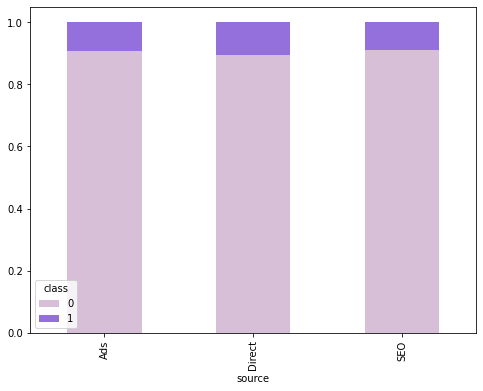

In [192]:
plot_proportion("source", fraud_df=fraud_df)

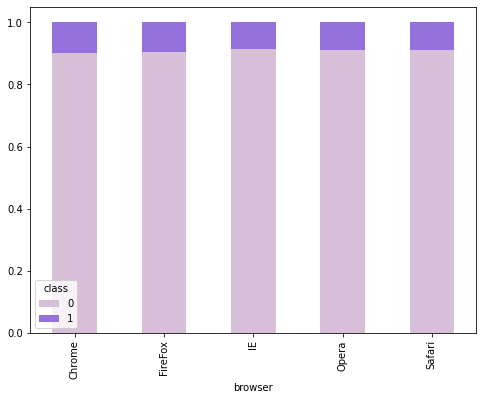

In [193]:
plot_proportion("browser", fraud_df=fraud_df)

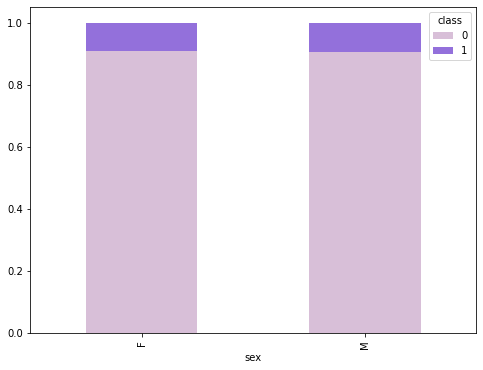

In [194]:
plot_proportion("sex", fraud_df=fraud_df)

In [195]:
fraud_df[["age", "purchase_value"]].describe()

,age,purchase_value
count,151112.000000,151112.000000
mean,33.140704,36.935372
std,8.617733,18.322762
min,18.000000,9.000000
25%,27.000000,22.000000
50%,33.000000,35.000000
75%,39.000000,49.000000
max,76.000000,154.000000


In [196]:
age_bins = [18, 25, 35, 40, 77]
age_labels = ["18-24", "25-34", "35-39", "40+" ]
value_bins = [9, 20, 35, 50, 155]
value_labels = ["9-19", "20-34", "35-49", "50+" ]

fraud_df["age_group"] = pd.cut(fraud_df["age"], bins=age_bins, labels=age_labels)
fraud_df["purchase_value_group"] = pd.cut(fraud_df["purchase_value"], bins=value_bins, labels=value_labels)

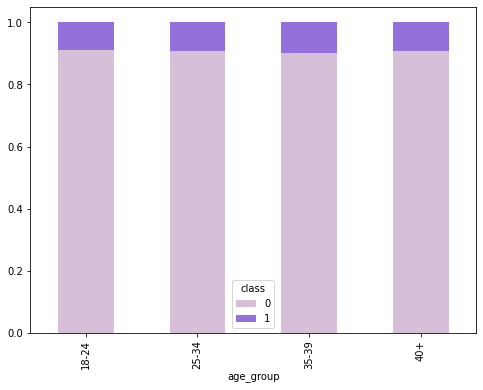

In [197]:
plot_proportion("age_group", fraud_df=fraud_df)

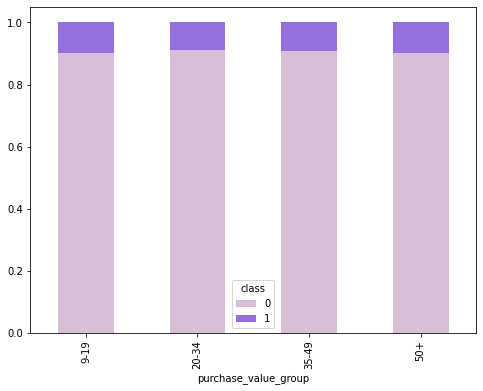

In [198]:
plot_proportion("purchase_value_group", fraud_df=fraud_df)

In [199]:
fraud_df["country"].value_counts(normalize=True)

United States     0.384146
Others            0.312768
NA                0.145362
China             0.079663
Japan             0.048348
United Kingdom    0.029713
Name: country, dtype: float64

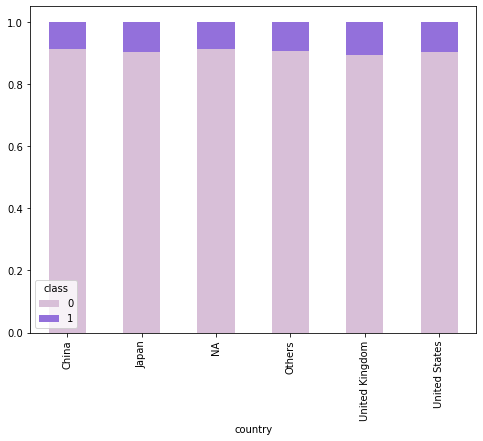

In [200]:
fraud_df["country"] = fraud_df["country"].apply(lambda x: x if x in ["United States", "NA", "China", "Japan", "United Kingdom"] else "Others")
plot_proportion("country", fraud_df=fraud_df)

### Comments：
- There's no noticeable relationship between these variables and the proportion of fradulent behaviors.

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


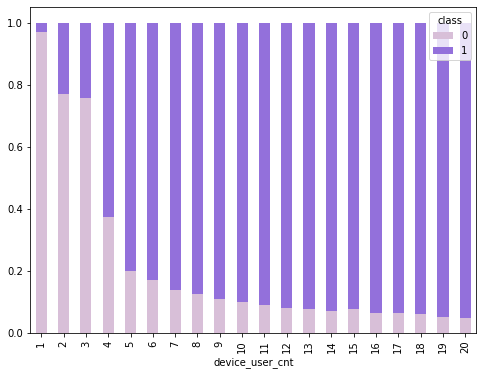

In [201]:
plot_proportion("device_user_cnt", fraud_df=fraud_df)

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


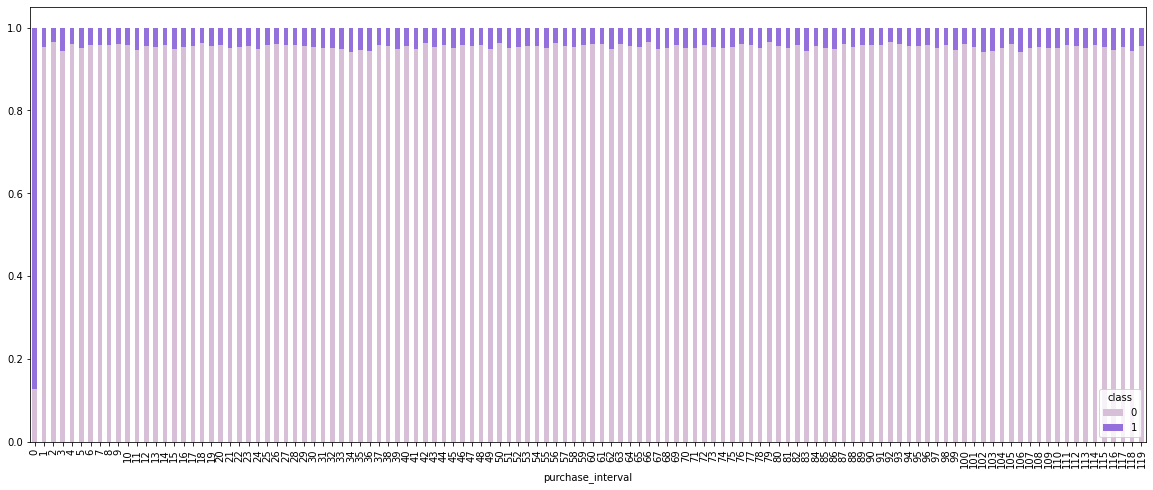

In [202]:
plot_proportion("purchase_interval", fraud_df=fraud_df, figsize=(20, 8))

### Comments：
- The likelihood of fraud increases as the number of users sharing the same device rises.
- When the first purchase time and signup time are the same day, the likelihood of fraud is extremely high.

In [212]:
model_df = fraud_df.copy()
labelencoder = LabelEncoder()
model_df["source"] = labelencoder.fit_transform(model_df["source"])
model_df["browser"] = labelencoder.fit_transform(model_df["browser"])
model_df["sex"] = labelencoder.fit_transform(model_df["sex"])
model_df["country"] = labelencoder.fit_transform(model_df["country"])

X = model_df[["purchase_value", "source", "browser", "sex", "age", "country", "purchase_interval", "device_user_cnt"]]
y = model_df["class"]

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [215]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9996880258654919, 0.9564124056999161)

<BarContainer object of 8 artists>

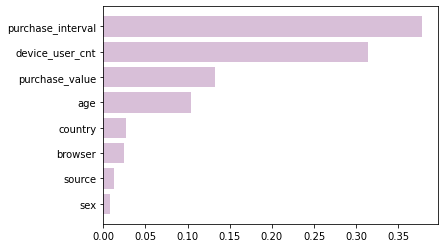

In [248]:
sort_df = pd.DataFrame({"column": X_train.columns, "feature_importance": clf.feature_importances_})\
.sort_values(by="feature_importance", ascending=True)
plt.barh(sort_df["column"], sort_df["feature_importance"], color=colors[0])

### Comments：
- Purchase interval, device_user_cnt, purchase_value and age are more importance features to classify whether the user is fradulent or not.


<Axes: xlabel='age', ylabel='Density'>

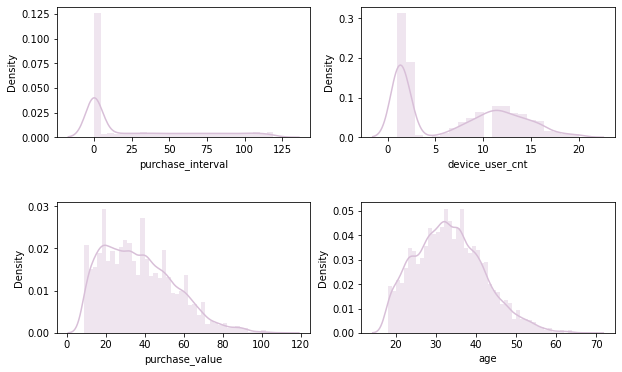

In [261]:
fraduent_df = fraud_df[fraud_df["class"] == 1]

fig, axs = plt.subplots(2,2,figsize=(10,6))
plt.subplots_adjust(hspace=0.5)

sns.distplot(fraduent_df["purchase_interval"], ax=axs[0, 0], color=colors[0])
sns.distplot(fraduent_df["device_user_cnt"], ax=axs[0, 1], color=colors[0])
sns.distplot(fraduent_df["purchase_value"], ax=axs[1, 0], color=colors[0])
sns.distplot(fraduent_df["age"], ax=axs[1, 1], color=colors[0])

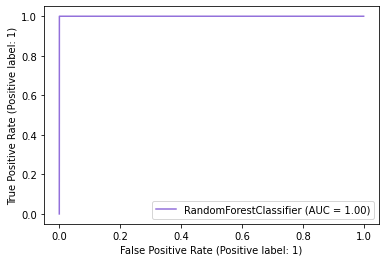

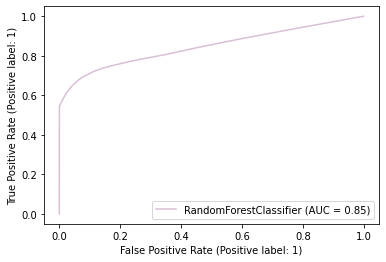

In [268]:
svc_disp_train = RocCurveDisplay.from_estimator(clf, X_train, y_train, color=colors[1])
svc_disp_test = RocCurveDisplay.from_estimator(clf, X_test, y_test, color=colors[0])
plt.show()

In [271]:
for threhold in [0.95, 0.8, 0.6, 0.4, 0.2, 0]:
    df = model_accuracy.copy()
    df["prediction"] = df["1_proba"].apply(lambda x: 1 if x >= threhold else 0)
    TP = df[(df["class"] == 1) & (df["prediction"] == 1)].shape[0]
    FN = df[(df["class"] == 1) & (df["prediction"] == 0)].shape[0]
    
    TN = df[(df["class"] == 0) & (df["prediction"] == 0)].shape[0]
    FP = df[(df["class"] == 0) & (df["prediction"] == 1)].shape[0]

    TPR = TP / (TP+FN)
    FPR = FP / (FP+TN)
    print(threhold, TPR, FPR)


0.95 0.5392459094142755 2.4320840528248657e-05
0.8 0.5425658050746976 7.296252158474597e-05
0.6 0.5447000237135404 0.0006809835347909624
0.4 0.5667536163149158 0.007271931317946349
0.2 0.6559165283376808 0.047547243232726126
0 1.0 1.0
